In [1]:
from decouple import config
from mvpa_functions import load_pickle, ados, extract, predictors_df
import os
import re
from nilearn.reporting import get_clusters_table
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiSpheresMasker
import nilearn.image as img 
import nilearn.plotting as nplot
from copy import deepcopy
import scipy
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Read in model and test images

In [2]:
img_dir = 'combined'
ml_dir = config('ml')
test_parameters = ados('G2' , test_train='test', directory=img_dir).reset_index(drop=True)
train_parameters = ados('G2', test_train='train', directory=img_dir).drop([20])
ml_models = {
    'space_net': dict(zip([re.sub('.pickle', '', key) for key in os.listdir(os.path.join(ml_dir, 'pickle', 'test_train_cv_10', img_dir))], 
                     [load_pickle(re.sub('\.pickle', '', os.path.join(os.path.join(ml_dir, 'pickle', 'test_train_cv_10', img_dir), pickle))) 
                      for pickle in os.listdir(os.path.join(ml_dir, 'pickle', 'test_train_cv_10', img_dir))])),
    'frem_svr': dict(zip([re.sub('.pickle', '', key) for key in os.listdir(os.path.join(ml_dir, 'pickle', 'test_train_cv_10', img_dir))], 
                     [load_pickle(re.sub('\.pickle', '', os.path.join(os.path.join(ml_dir, 'frem_best_estimator'), pickle))) 
                      for pickle in os.listdir(os.path.join(ml_dir, 'frem_best_estimator'))])),

}

## Calculate performance metrics

In [3]:
%%capture
test_stats =  dict(zip([key for key in ml_models.keys()], [dict(zip([domain for domain in ml_models['space_net'].keys()],
                                                                    [{} for domain in ml_models['space_net'].keys()])) for key in ml_models.keys()]))

for algo in ml_models.keys():
    for model in ml_models['space_net'].keys():
        test_stats[algo][model]['y_pred'] = ml_models[algo][model].predict(test_parameters['paths']).ravel()
        test_stats[algo][model]['r2'] = ml_models[algo][model].score(test_parameters['paths'], test_parameters[model])
        test_stats[algo][model]['mse'] = np.mean(np.abs(test_parameters[model] - test_stats[algo][model]['y_pred']))

In [4]:
for model in test_stats['space_net'].keys():
      print(f"Mean square error for {model}:\n", 
            f"space net: {test_stats['space_net'][model]['mse']},",
            f"frem svr: {test_stats['frem_svr'][model]['mse']},")
      print(f"R2 {model}:\n ", 
            f"space net: {test_stats['space_net'][model]['r2']},",
            f"frem svr: {test_stats['frem_svr'][model]['r2']},",
            "\n")

Mean square error for ADOS_com_soc:
 space net: 1.9720415936864164, frem svr: 2.1450546406830506,
R2 ADOS_com_soc:
  space net: -0.016582227975307617, frem svr: -0.07822979464243174, 

Mean square error for ADOS_Communication:
 space net: 1.523109129307058, frem svr: 1.5254718827409954,
R2 ADOS_Communication:
  space net: -0.18789761478038058, frem svr: 0.000138564595368873, 

Mean square error for ADOS_Interaction:
 space net: 0.8664021169469338, frem svr: 1.1368704024655256,
R2 ADOS_Interaction:
  space net: -2.086099282990888, frem svr: -4.134771159561651, 

Mean square error for ADOS_sterotyped_and_repetititve:
 space net: 1.201012940947234, frem svr: 0.8420318912040441,
R2 ADOS_sterotyped_and_repetititve:
  space net: -0.41186762363394736, frem svr: 0.17674856299291808, 

Mean square error for ADOS_Creativity:
 space net: 0.4817565430100168, frem svr: 0.858427903049831,
R2 ADOS_Creativity:
  space net: 0.040245018355894224, frem svr: -3.1790255567400125, 



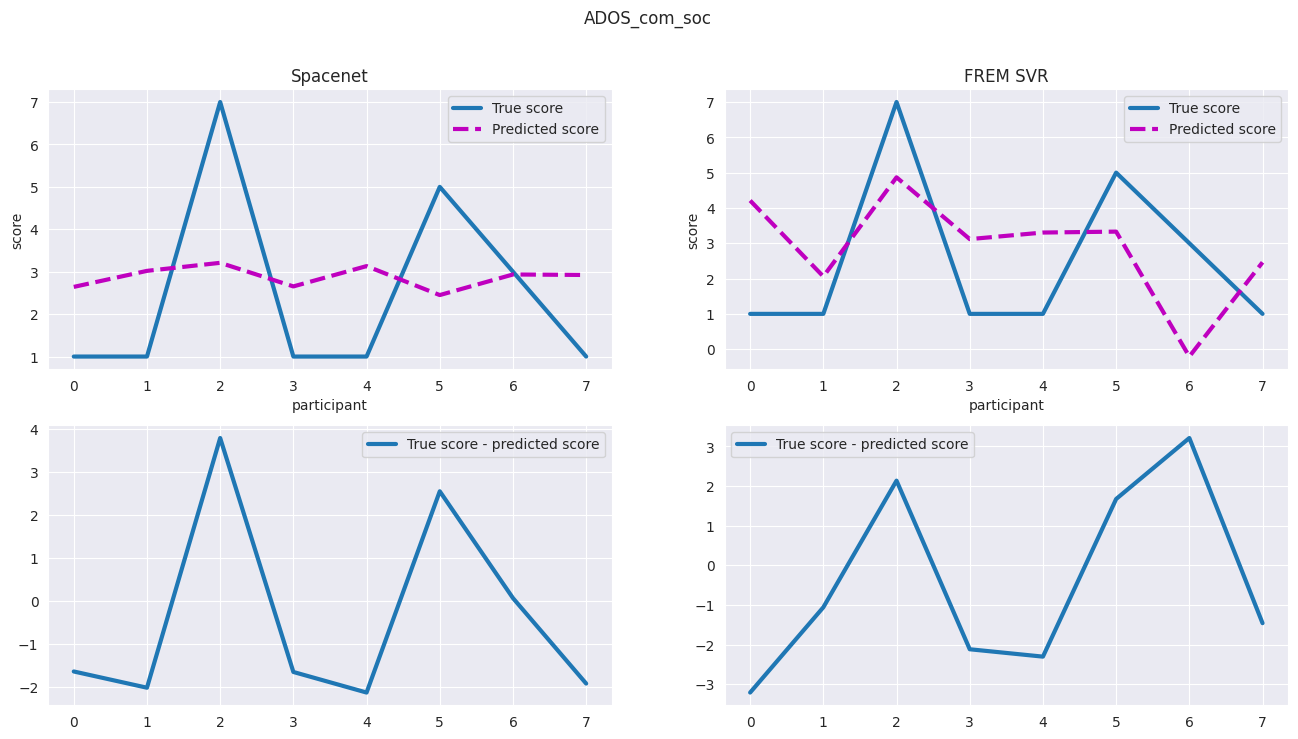

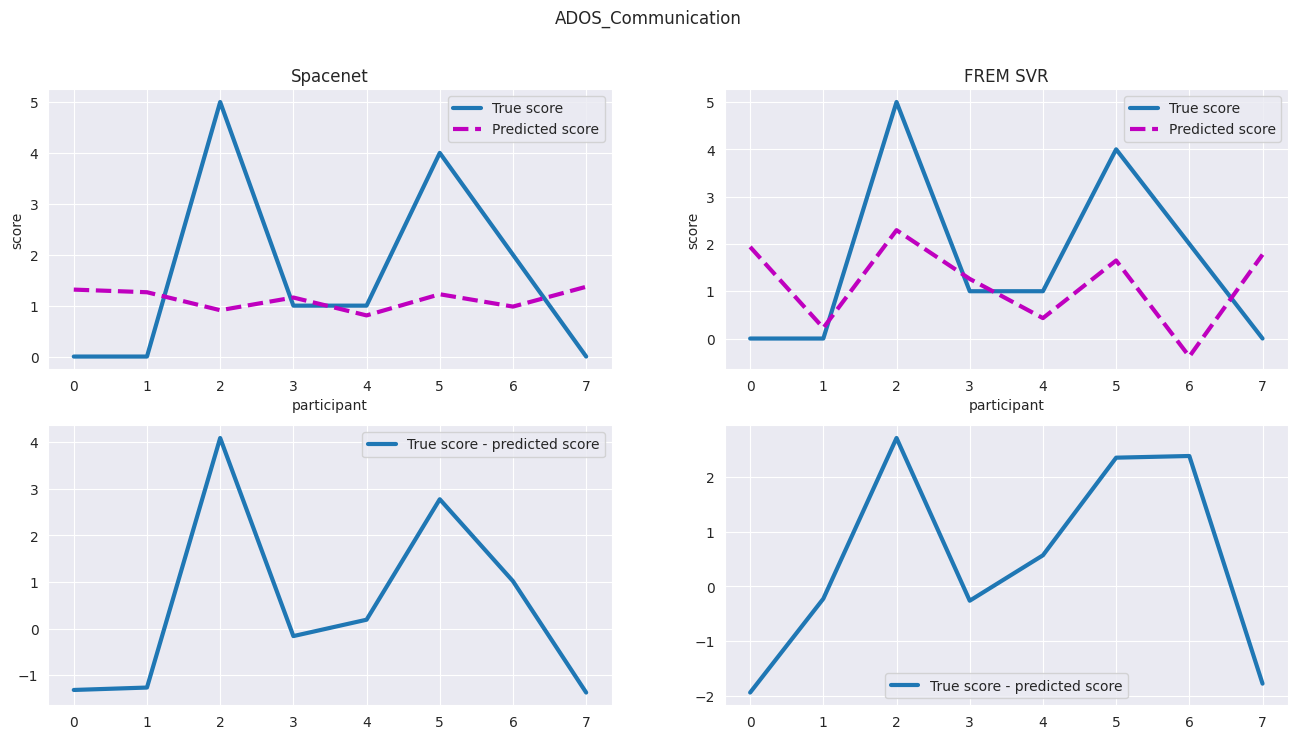

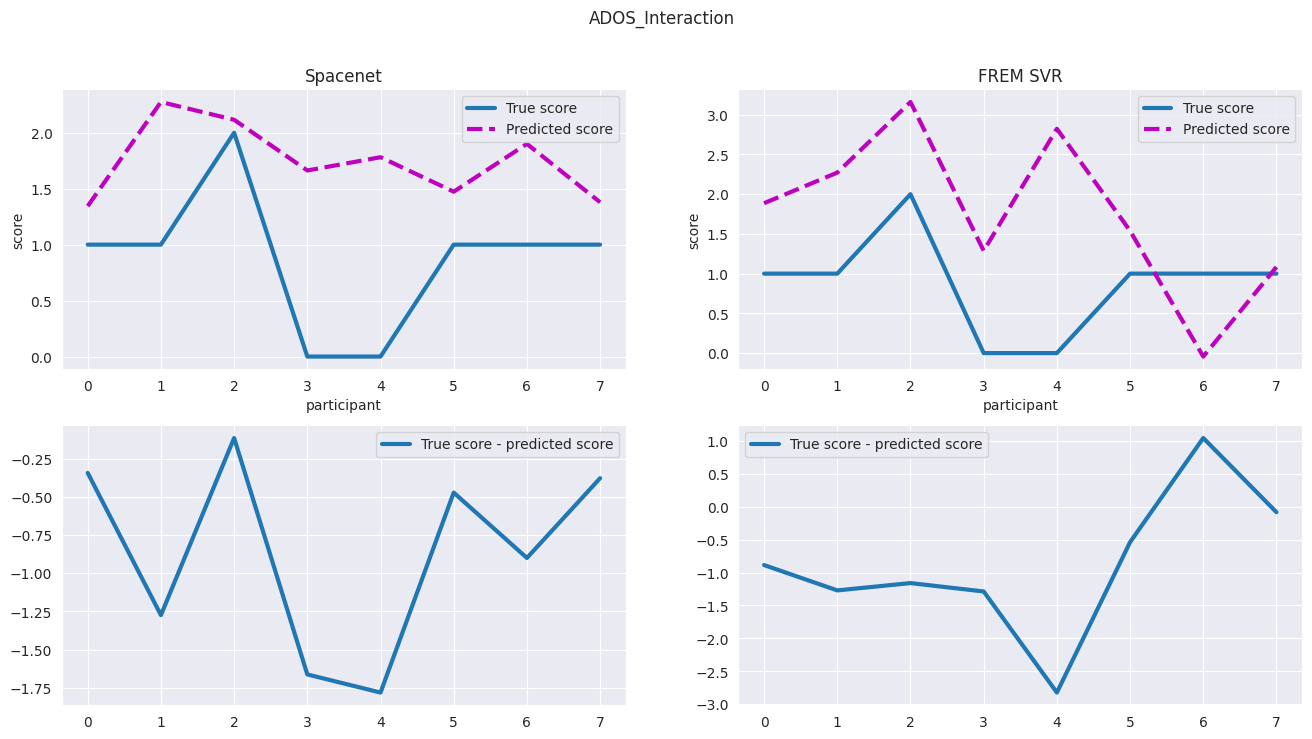

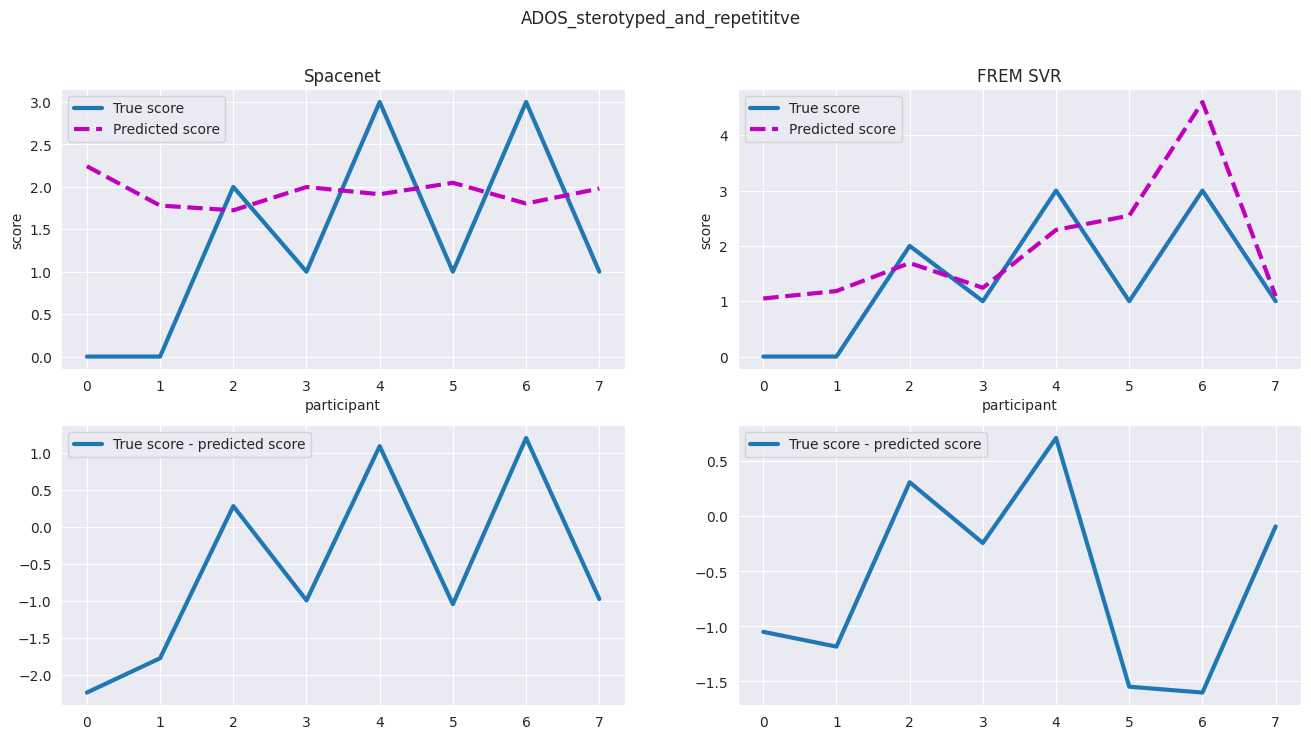

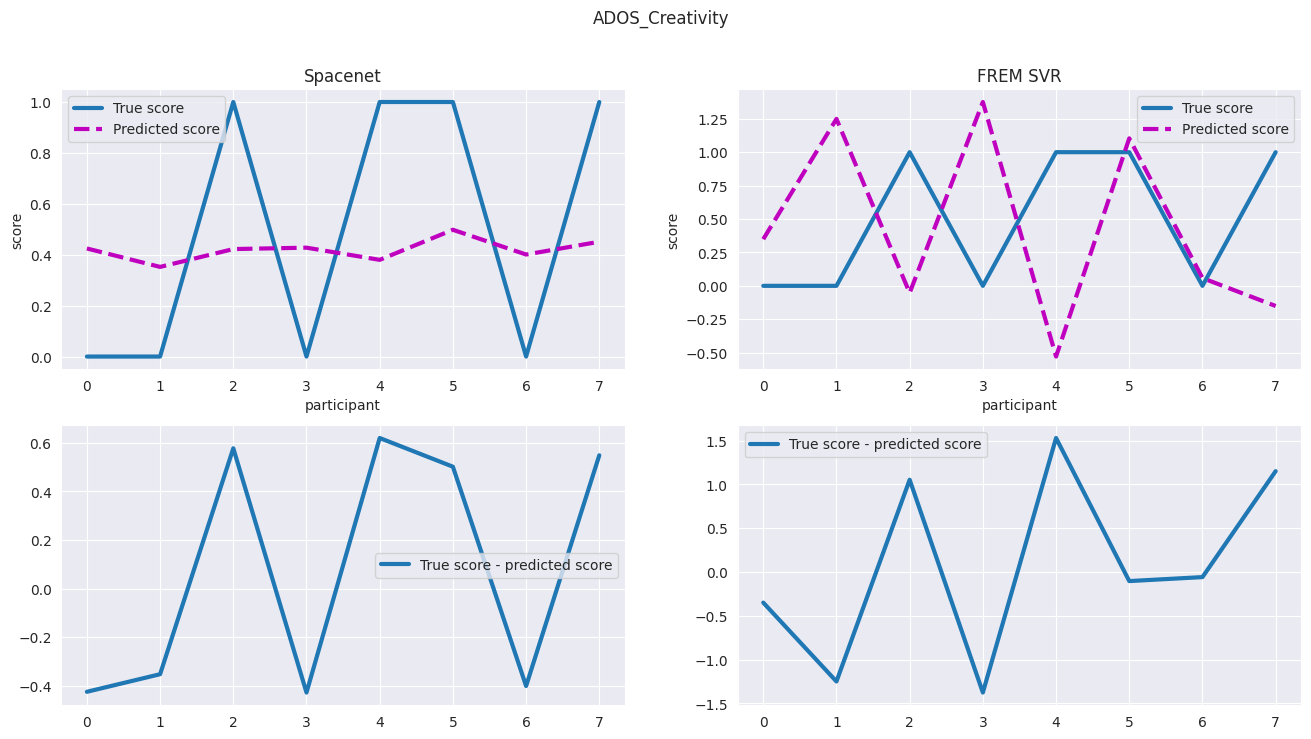

In [5]:
for model in test_stats['space_net'].keys():
    fig,ax = plt.subplots(2,2, figsize=(16,8))
    plt.suptitle(f"{model}")
    ax[0][0].plot(test_parameters[model], label="True score", linewidth=3)
    ax[0][1].plot(test_parameters[model], label="True score", linewidth=3)
    ax[0][0].plot(test_stats['space_net'][model]['y_pred'], "--", c="m", label="Predicted score", linewidth=3)
    ax[0][1].plot(test_stats['frem_svr'][model]['y_pred'], "--", c="m", label="Predicted score", linewidth=3)
    ax[0][0].set_ylabel("score")
    ax[0][1].set_ylabel("score")
    ax[0][0].set_xlabel("participant")
    ax[0][1].set_xlabel("participant")
    ax[0][0].set_title('Spacenet')
    ax[0][1].set_title('FREM SVR')
    ax[0][0].legend(loc="best")
    ax[0][1].legend(loc="best")
    ax[1][0].plot(test_parameters[model] - test_stats['space_net'][model]['y_pred'], label="True score - predicted score", linewidth=3)
    ax[1][1].plot(test_parameters[model] - test_stats['frem_svr'][model]['y_pred'], label="True score - predicted score", linewidth=3)
    ax[1][0].legend(loc="best")
    ax[1][1].legend(loc="best")

## Plot weights for models with non-negative Rsquared

In [6]:
r2_models = {}
for algo in test_stats.keys():
    for model in test_stats['space_net'].keys():
        if test_stats[algo][model]['r2'] > 0:
            r2_models[f'{algo}_{model}'] = ml_models[algo][model]

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


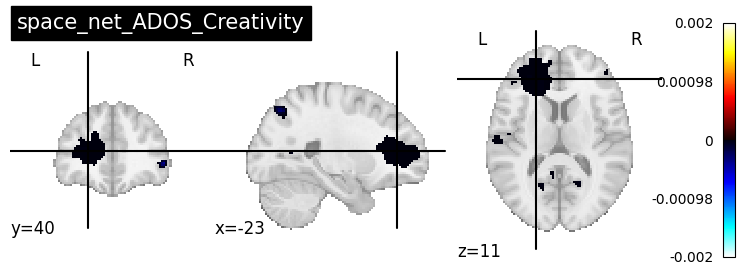

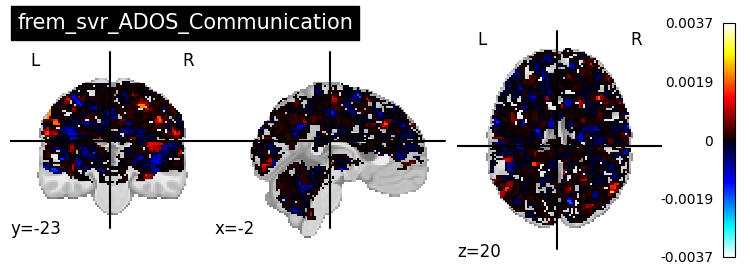

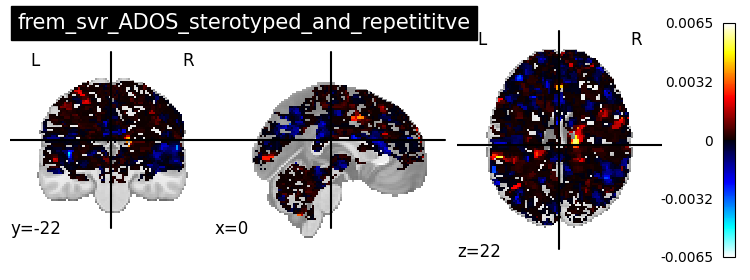

In [7]:
for model in r2_models.keys():
    img_r2 = r2_models[model].coef_img_
    if 'frem' in model:
        img_r2 = r2_models[model].coef_img_['beta']
    nplot.plot_stat_map(
        img_r2,
        title=model,
    )

## Examine Weights and weight distribution

In [8]:
frem_img_stereo = deepcopy(r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'])
frem_img_communication = deepcopy(r2_models['frem_svr_ADOS_Communication'].coef_img_['beta'])
space_img = deepcopy(r2_models['space_net_ADOS_Creativity'].coef_img_)
frem_betas_stereo = pd.Series(frem_img_stereo.get_fdata().ravel()).describe()
frem_betas_communication = pd.Series(frem_img_communication.get_fdata().ravel()).describe()
space_betas = pd.Series(space_img.get_fdata().ravel()).describe()
display('FREM ADOS_sterotyped_and_repetititve', frem_betas_stereo)
display('FREM ADOS_Communication', frem_betas_communication)
display('SPACE NET ADOS_Creativity',space_betas) #ADOS_Communication

'FREM ADOS_sterotyped_and_repetititve'

count    1.082035e+06
mean    -3.328742e-07
std      2.111254e-04
min     -6.478027e-03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.570809e-03
dtype: float64

'FREM ADOS_Communication'

count    1.082035e+06
mean    -9.603574e-07
std      1.467375e-04
min     -3.419450e-03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.727159e-03
dtype: float64

'SPACE NET ADOS_Creativity'

count    1.082035e+06
mean    -2.828230e-07
std      1.121013e-05
min     -1.955849e-03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.801038e-06
dtype: float64

## Examine which weights are significant predictors

### For Spacenet model

In [9]:
t_score_spacenet = r2_models['space_net_ADOS_Creativity'].Xmean_ / r2_models['space_net_ADOS_Creativity'].Xstd_
p_value = scipy.stats.t.sf(np.abs(t_score_spacenet), df=163653-1 )*2
if p_value[p_value<0.05].size == 0:
    print('No significant predictors')

No significant predictors


### FREM model ADOS sterotyped and repetititve

In [10]:
t_score_img_frem_stereo = img.math_img("img_1/img_2",
    img_1=r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'],
    img_2 = r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].std_coef_img_['beta'])
p_value_img_frem_stereo = deepcopy(t_score_img_frem_stereo)
p_value_data_stereo = p_value_img_frem_stereo.get_fdata()
array_pvalues_stereo = scipy.stats.t.sf(np.abs(p_value_data_stereo), df=1082035-1)*2
pval_img_stereo = img.new_img_like(p_value_img_frem_stereo, array_pvalues_stereo)
neg_log_10_stereo = img.math_img("-np.log10(pval)", pval=pval_img_stereo)

<string>:1: RuntimeWarning: invalid value encountered in divide


#### plot T scores and p values


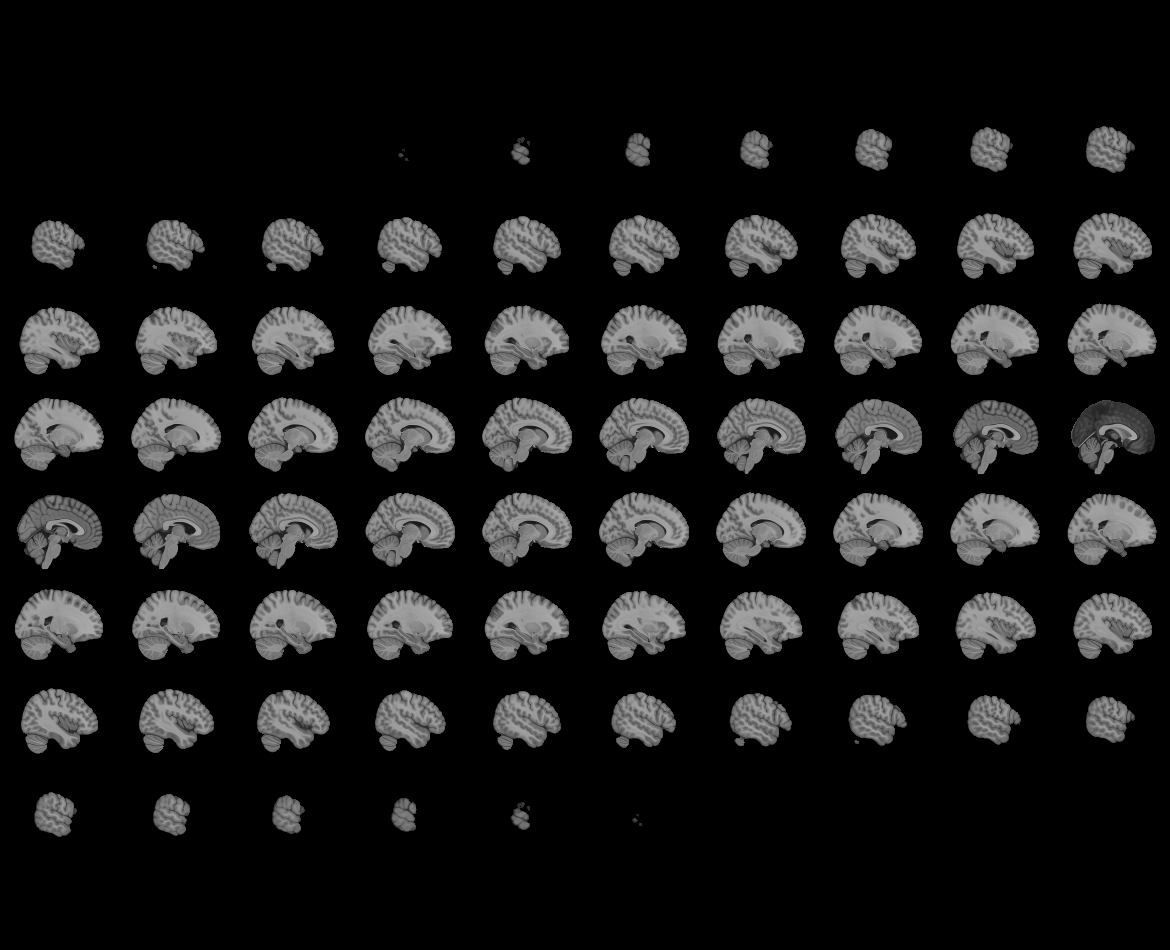
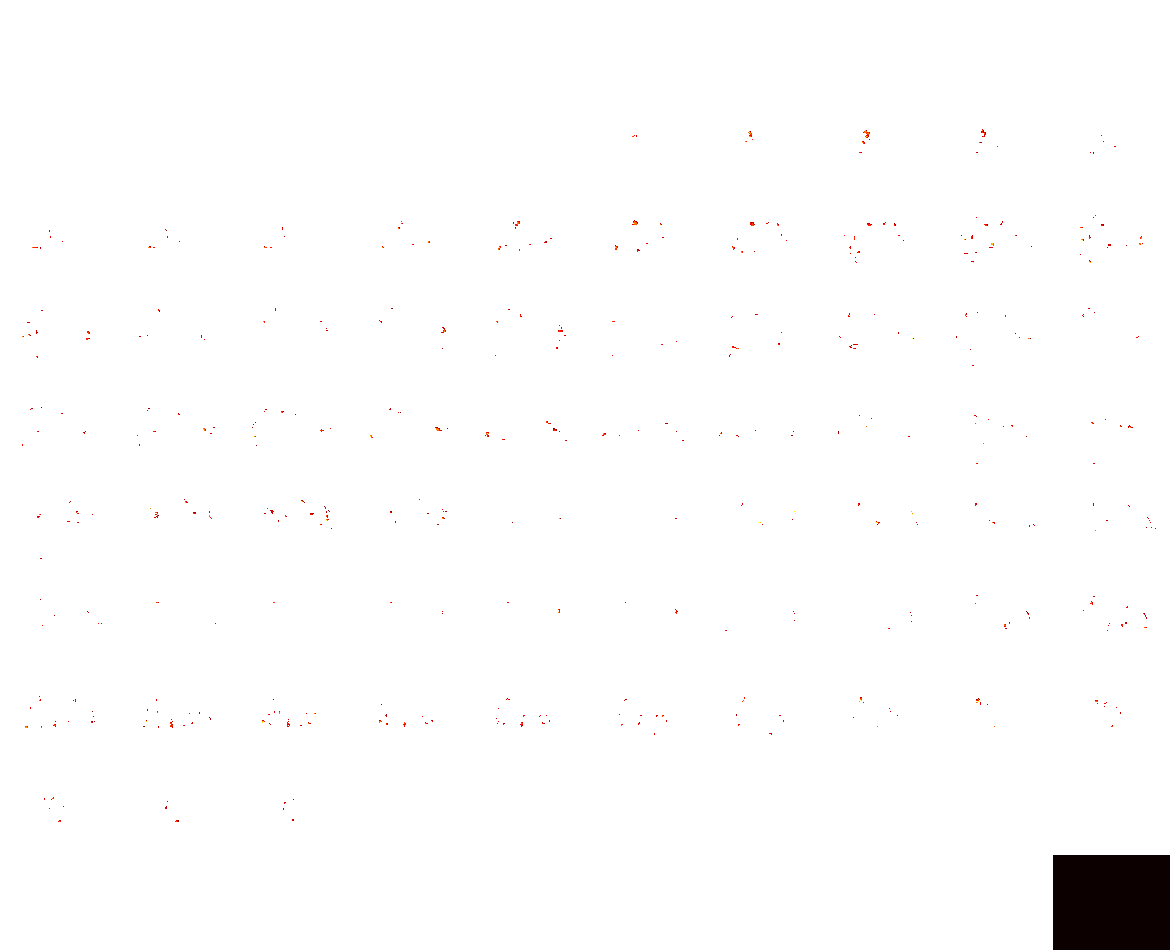

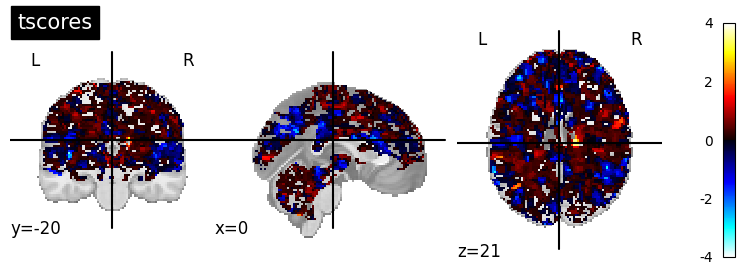

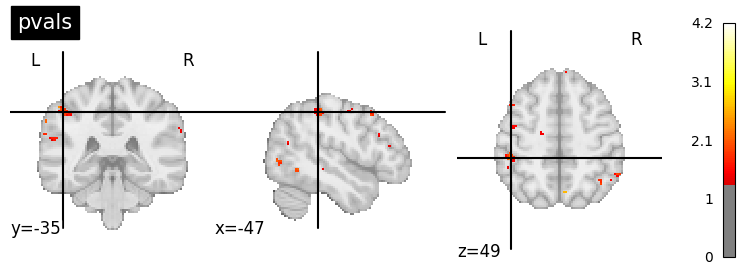

In [11]:
nplot.plot_stat_map(t_score_img_frem_stereo, title='tscores')
nplot.plot_stat_map(neg_log_10_stereo, threshold=-np.log10(0.05), title='pvals')
nplot.view_img(neg_log_10_stereo, threshold=-np.log10(0.05), title='pvals')

#### Extract regions that are signficant predictors

In [12]:
if 'frem_svr_ADOS_sterotyped_and_repetititve_sig_predictors.csv' in os.listdir(ml_dir):
    frem_predictors_df_stereo = pd.read_csv(f'{ml_dir}/frem_svr_ADOS_sterotyped_and_repetititve_sig_predictors.csv').drop('Unnamed: 0', axis=1)
else:
    frem_predictors_stereo = get_clusters_table(neg_log_10_stereo, stat_threshold=-np.log10(0.05))
    frem_predictors_stereo['pval'] = 10 ** -frem_predictors_stereo['Peak Stat'].values
    coords_stereo = frem_predictors_stereo[['X', 'Y', 'Z']]
    beta_t_stereo = extract(coords_stereo, r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'], t_score_img_frem_stereo)
    frem_predictors_df_stereo = pd.concat((frem_predictors_stereo, beta_t_stereo), axis=1).drop('Peak Stat', axis=1)
    frem_predictors_df_stereo = predictors_df(frem_predictors_df_stereo, frem_predictors_df_stereo[['X', 'Y', 'Z']])
    frem_predictors_df_stereo.to_csv(f'{ml_dir}/frem_svr_ADOS_sterotyped_and_repetititve_sig_predictors.csv')

### FREM ADOS Communication

In [13]:
t_score_img_frem_comms = img.math_img("img_1/img_2",
    img_1=r2_models['frem_svr_ADOS_Communication'].coef_img_['beta'],
    img_2 = r2_models['frem_svr_ADOS_Communication'].std_coef_img_['beta'])
p_value_img_frem_comms = deepcopy(t_score_img_frem_comms)
p_value_data_comms = p_value_img_frem_comms.get_fdata()
array_pvalues_comms = scipy.stats.t.sf(np.abs(p_value_data_comms), df=1082035-1)*2
pval_img_comms = img.new_img_like(p_value_img_frem_comms, array_pvalues_comms)
neg_log_10_comms = img.math_img("-np.log10(pval)", pval=pval_img_comms)

<string>:1: RuntimeWarning: invalid value encountered in divide


#### Plot T scores and P-values


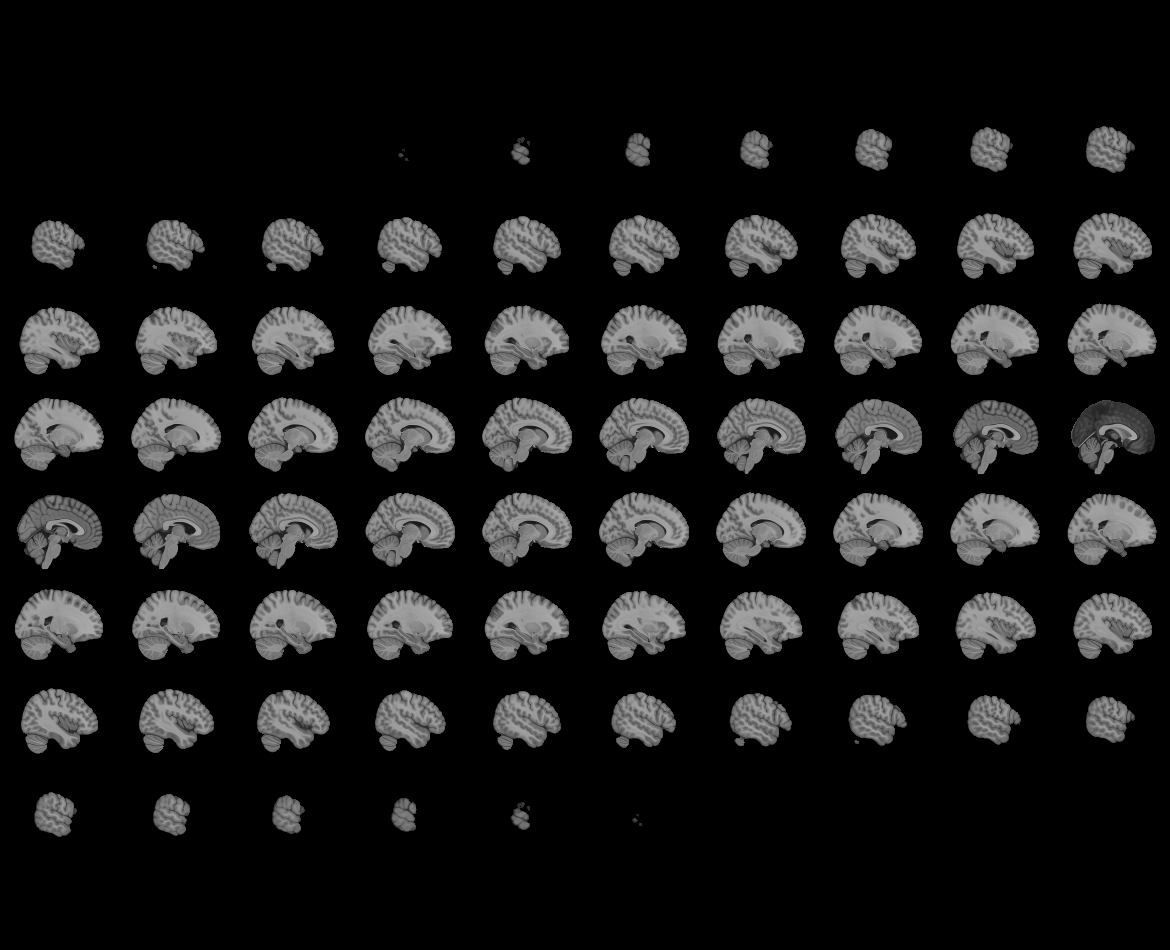
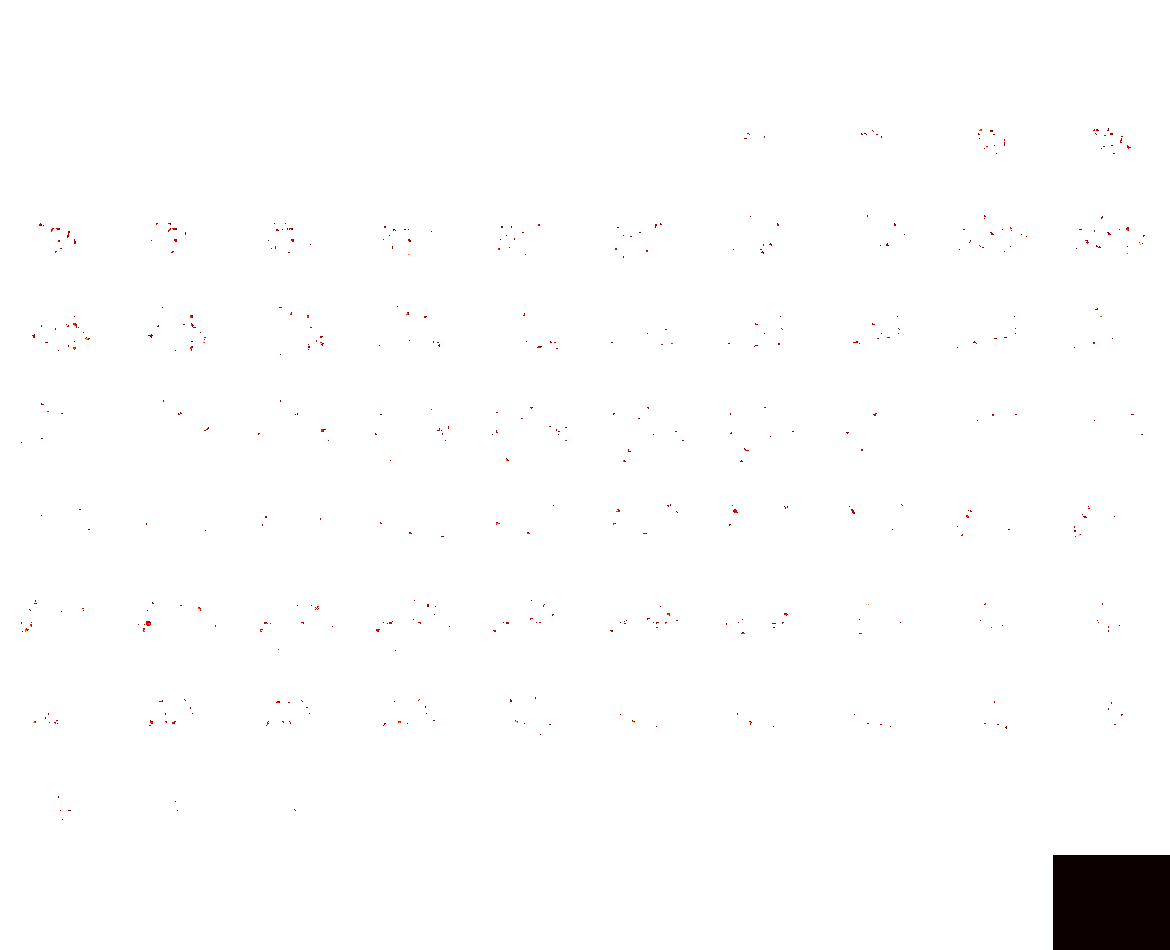

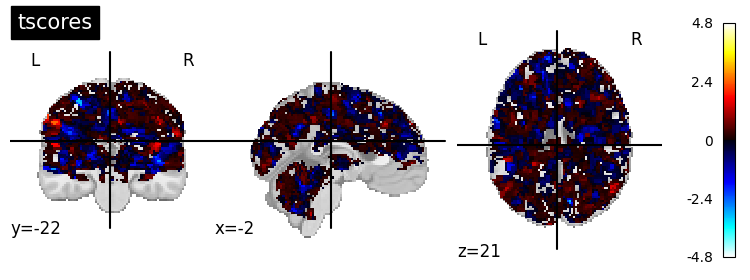

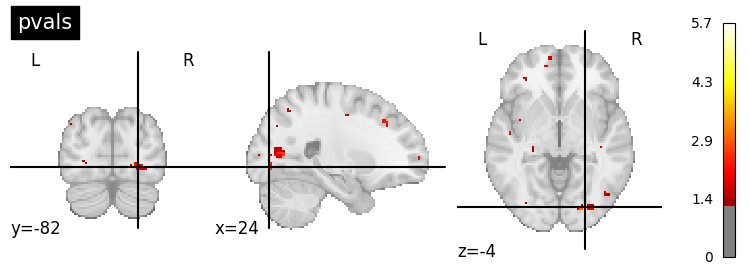

In [14]:
nplot.plot_stat_map(t_score_img_frem_comms, title='tscores')
nplot.plot_stat_map(neg_log_10_comms, threshold=-np.log10(0.05), title='pvals')
nplot.view_img(neg_log_10_comms, threshold=-np.log10(0.05), title='pvals')

#### Extract regions that are signficant predictors

In [15]:
if 'frem_svr_ADOS_Communication_sig_predictors.csv' in os.listdir(ml_dir):
    frem_predictors_df_comms = pd.read_csv(f'{ml_dir}/frem_svr_ADOS_Communication_sig_predictors.csv').drop('Unnamed: 0', axis=1)
else:
    frem_predictors_comms = get_clusters_table(neg_log_10_comms, stat_threshold=-np.log10(0.05))
    frem_predictors_comms['pval'] = 10 ** -frem_predictors_comms['Peak Stat'].values
    coords_comms = frem_predictors_comms[['X', 'Y', 'Z']]
    beta_t_comms = extract(coords_comms, r2_models['frem_svr_ADOS_Communication'].coef_img_['beta'], t_score_img_frem_comms)
    frem_predictors_df_comms = pd.concat((frem_predictors_comms, beta_t_comms), axis=1).drop('Peak Stat', axis=1)
    frem_predictors_df_comms = predictors_df(frem_predictors_df_comms, frem_predictors_df_comms[['X', 'Y', 'Z']])
    frem_predictors_df_comms.to_csv(f'{ml_dir}/frem_svr_ADOS_Communication_sig_predictors.csv')

#### See if differences found from second level are significant predictors 

In [19]:
for task in ['happy', 'eft', 'fear']:
    try: 
        cluster_df = pd.read_csv(os.path.join(config(task), '2ndlevel', 'interaction_clusters.csv'))
    except Exception:
        cluster_df = pd.read_csv(os.path.join(config(task), '2ndlevel', 'time_clusters.csv'))
    coords = cluster_df[['peak_x', 'peak_y', 'peak_z']]
    betas_df_stereo = extract(coords, r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'], t_score_img_frem_stereo )
    betas_df_comms = extract(coords, r2_models['frem_svr_ADOS_Communication'].coef_img_['beta'], t_score_img_frem_comms)
    pval_stero = NiftiSpheresMasker((coords.values)).fit_transform(pval_img_stereo)
    pval_comms = NiftiSpheresMasker((coords.values)).fit_transform(pval_img_comms)
    betas_df_stereo['pval'] = pd.Series(pval_stero.ravel())
    betas_df_comms['pval'] = pd.Series(pval_comms.ravel())
    display_df = cluster_df[['harvard_oxford']]
    if task == 'happy':
        display_df = cluster_df[['aal']]
    display(task, pd.concat((display_df, 
                             betas_df_stereo.rename(columns={'beta': 'beta_stereo', 
                                                             't_score': 'tscore_stereo',
                                                             'pval': 'pval_stereo'}), 
                             betas_df_comms.rename(columns={'beta': 'beta_comms',
                                                            't_score': 't_score_comms',
                                                            'pval': 'pval_comms'})), axis=1))

'happy'

,aal,beta_stereo,tscore_stereo,pval_stereo,beta_comms,t_score_comms,pval_comms
0,75.00% Vermis_4_5; 25.00% Cerebelum_4_5_L,0.000055,0.201962,0.839946,-0.000115,-0.531096,0.595352


'eft'

,harvard_oxford,beta_stereo,tscore_stereo,pval_stereo,beta_comms,t_score_comms,pval_comms
0,72.73% Right_Frontal_Operculum_Cortex; 27.27% ...,-0.000059,-0.077689,0.938075,0.000226,0.344779,0.730261
1,100.00% Right_Frontal_Pole,0.000061,0.142857,0.886403,-0.000012,-0.245980,0.805698
2,100.00% Right_Planum_Temporale,0.000036,0.142857,0.886403,0.000000,0.000000,0.000000
3,100.00% Right_Putamen,0.000060,0.175609,0.860601,-0.000006,-0.025748,0.979458
4,100.00% Left_Precentral_Gyrus,-0.000034,-0.142857,0.886403,-0.000580,-0.834905,0.403771
5,100.00% Left_Precentral_Gyrus,0.000000,0.000000,0.000000,-0.000620,-0.955322,0.339415


'fear'

,harvard_oxford,beta_stereo,tscore_stereo,pval_stereo,beta_comms,t_score_comms,pval_comms
0,40.37% Left_Frontal_Pole; 13.30% no_label; 10....,0.000029,0.075164,0.940085,5.301777e-07,0.001613,0.998713


In [21]:
frem_predictors_df_stereo['labels'].drop_duplicates().reset_index()

,index,labels
0,0,"Right Lateral Occipital Cortex, inferior division"
1,1,Left Heschl's Gyrus (includes H1 and H2)
2,4,"Left Supramarginal Gyrus, anterior division"
3,5,Temporal_Sup_R
4,6,Right Precuneous Cortex
...,...,...
63,243,Lingual_L
64,246,"Right Superior Temporal Gyrus, anterior division"
65,250,Thalamus_R
66,258,Left Parietal Operculum Cortex
